<a href="https://colab.research.google.com/github/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_2/extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electric fields

Let's move away from CFD and study the case of the electric field, as a way to investigate the more general class of algorithms known as relaxation methods. These are used to determine the **equilibrium** configuration of a field when only some boundary conditions are known. The methods used are the same as in CFD, since we are dealing with partial differential equations.

It is convenient to work on the electric *potential* $V$ rather than directly with the electric field $\vec{E}$, since the potential is a scalar quantity and the electris field can be simply computed from the potential via

$$
\vec{E} = - \vec{\nabla} V \equiv - \left( \frac{\partial V}{\partial x}, \frac{\partial V}{\partial y}, \frac{\partial V}{\partial z} \right)
$$

## Laplace equation
The electric potential $V$ obeys Laplace's equation:

$$
\nabla^2 V\equiv \frac{\partial^2 V}{\partial x^2} +  \frac{\partial^2 V}{\partial y^2} +  \frac{\partial^2 V}{\partial z^2}  = - \frac{\rho}{\epsilon} ,
$$

where $\rho$ is the density of electric charges and $\epsilon$ is the so-called permittivity, i.e. a constant that describes how the medium in reacts to charges placed in it. In particular, you can see that the higher the permittivity, the smaller the electrical potential generated by a given charge density. Throughout this lecture, we will assume that all charges are placed in vacuum, i.e. $\epsilon = \epsilon_0 = 8.8542 \times 10^{-12}$ s$^{4}$A$^{2}$kg$^{-1}$m$^{-3}$.

## The no-free-charges case
When approaching a new problem, it is always useful to start from the simplest case possible. In our case, we assume that there are no charges *in the region of space where we want to compute the electric potential*. Of course, in order to have an electric potential, there must be charges *somewhere*. For now, however, we will assume they are not in the region of interest.

Under this assumption, the right-hand side of Laplace's equation is zero. Therefore, we are trying to solve the following equation:

$$
\nabla^2 V \equiv \frac{\partial^2 V}{\partial x^2} +  \frac{\partial^2 V}{\partial y^2} +  \frac{\partial^2 V}{\partial z^2} = 0.
$$

After replacing the finite difference estimate of $\nabla^2$, we can solve for $V_{i,j,k}$, obtaining:

$$
V_{i,j,k} \approx \frac{1}{6} \left[ V_{i+1,j,k}+V_{i-1,j,k}+V_{i,j+1,k}+V_{i,j-1,k}+V_{i,j,k+1}+V_{i,j,k+1} \right]
$$

Since there are no charges and we are in vacuum, ther problem is inherently **static**, i.e. there is no time evolution. As such, differently from previous cases (like the solar system evolution), we do not have initial conditions. In fact, if we had them, the problem would be solved already, as the system does not evolve at all. Instead, we usually have some *boundary* conditions, i.e. we (somehow) know the value of $V$ on the boundary of the region of space we are interested in. For example, there is a plate kept at fixed potential, or we know that the potential should vanish at very large distances from the charges.

Our task is to find a configuration of $V$ that satisfies at the same time the Laplace equation and the boundary conditions. Unfortunately, there is no one-size-fits-all method for this. On the contrary, there are a number of different methods that can be used. In the following, we will use one of the most common, the **relaxation method**.

## The relaxation method(s)

At its core, the relaxation methods are **iterative procedures** that transforms an initial guess to the correct solution. It relies on the fact that for a *static* problem, applying the Laplace equation to the (potential) field, leaves it unchanged.

The simplest relaxation method is known as *Jacobi method* and proceeds by iteratively applying Laplace's equation to the initial guess $V^{(0)}_{i,j,k}$, in order to obtain a better estimate of the solution. The iteration stops when a *convergence criterion* is met. Therefore, the main parts of this algorithm (for our application) are:
* make an initial guess for the solution $V^{(0)}_{i,j,k}$
* use Laplace's equation to make a new estimate $V^{(1)}_{i,j,k}$
* check if the convergence criterion is met.
    * If yes, stop
    * If not, repeat
    
### Convergence criterion
A crucial step in any iterative process is to decide when the iteration should stop, i.e. the so-called convergence criterion. This decision determines the **accuracy** of the final solution. However, it is not always clear what such criterion should be. For instance, we may require some level of accuracy to be reached. In this case, we would stop the iteration when the difference between two subsequent iteration is smaller than (a fraction of) the level of accuracy needed. In other situation, we do not have such external constrain. We could, therefore, require that the *relative* change between to subsequent iteration is below some threshold.

Even when the threshold is set, we still have to face the question: *How do we compute the change of a 3D field?* We could, for instance, sum the individual absolute change in each grid point (mathematically, this is called L1-norm). Alternatively, we could just look at the maximum variation among the grid points. In this case as well, the choice is problem-dependent.

### Implementation
As always, it is useful to break down complex algorithms in many simple tasks. The Jacobi method outlined above provides a clear path forward to such break down. Therefore, we will now try to write functions that achieve each one (and only one!) of the above steps. But first, let's load some useful modules...

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#import warnings
#warnings.filterwarnings('ignore')
from scipy.stats import binned_statistic

#### Set up
First of all, we need a function that prepares the grid over which we discretize the equations, and provides an initial guess. In principle, we could save the estimate of $V$ at each iteration. Practically, however, this requires a lot of memory, since the number of iterations can be very large. Looking at the Jacobi method, we realize that we only need to store the current and the next estimates. Therefore, we just need two grids.

Additionally, it is usually a good idea to set a maximum number of iterations allowed. In such a way we will not be studk in an infinite loop, should the method not converge. Here, we set such maximum number and the counter keeping track of it.

In [ ]:
Npoints_per_dimension = 30
max_iterations_allowed = 10000
iteration_number = 0

#optional: make sure Npoints_per_dimension is an integer, otherwise numpy will (rightfully) complain
assert( isinstance(Npoints_per_dimension, int) )

#create the two grids
current_guess = np.zeros((Npoints_per_dimension, Npoints_per_dimension, Npoints_per_dimension))
new_guess     = np.zeros((Npoints_per_dimension, Npoints_per_dimension, Npoints_per_dimension))

#set up initial guess
current_guess[:,:,:] = 0.0

#### Boundary conditions
We need a function that applies the boundary conditions to our estimates. This is completely problem-dependent, so we will just write an 'empty' function here, to show the design principle.

In [ ]:
def apply_boundary_conditions(estimate):
    estimate[0, :, :] = 1
    estimate[-1, :, :] = -1
    return estimate

#### Update guess
This function is the core of the relaxation method and takes care of estimating the new guess from the current one. Here, we do not update the boundaries, as this are fixed by the boundary conditions.

In [ ]:
def update_guess():
    for i in range(1, Npoints_per_dimension-1):
        for j in range(1, Npoints_per_dimension-1):
            for k in range(1, Npoints_per_dimension-1):
                new_guess[i,j,k] = (current_guess[i+1,j,k] + current_guess[i-1,j,k]
                                   +current_guess[i,j+1,k] + current_guess[i,j-1,k]
                                   +current_guess[i,j,k+1] + current_guess[i,j,k-1]
                                   ) / 6.0
    return

#### Check convergence
As discussed above, there are many different ways of defining convergence. In this initial example, we will look at the total relative change in the estimates. This means that convergence is reached if and only if
$$
\sum_{i,j,k} | V_{i,j,k}^{(i+1)} / V_{i,j,k}^{(i)} - 1| < \varepsilon_{conv}
$$
where $\varepsilon_{conv}$ is a user-defined convergence threshold.

In [ ]:
def is_converged(threshold=1e-5):
    abs_ratio = np.abs( new_guess / current_guess - 1 )  # = (new_guess - current_guess) / current_guess
    #remove boundaries because of boundary conditions
    tot = abs_ratio[1:-1, 1:-1, 1:-1].sum()
    if tot <= threshold:
        return True
    else:
        return False

#### The complete loop
Now, we are ready to combine all the functions into a complete relaxation algorithm. For simplicity, we will use the variable `running` to keep track whether we should keep running or not.

It is important that, if the method has not converged, the new guess is moved to `current_guess`, so that the next iteration will use the updated guess. Additionally, we need to check if the maximum number of iterations was reached and act accordingly.

In [ ]:
running = True

apply_boundary_conditions(current_guess)
apply_boundary_conditions(new_guess)

while running:
    print(f"iteration {iteration_number}", end='\r')
    update_guess()

    if is_converged(threshold=1e-1):
        print(f"SUCCESS! Convergence reached (after {iteration_number} iterations)!")
        running=False
    elif iteration_number >= max_iterations_allowed:
        print(f"WARNING: Maximum number of iterations ({max_iterations_allowed}) reached! The result is *not* converged to the desired level!")
        running=False
    else:
        current_guess = new_guess.copy()
        iteration_number += 1

iteration 0
iteration 1
iteration 2


/home/egaraldi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/egaraldi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


SUCCESS! Convergence reached (after 689 iterations)!


### Relaxation methods as diffusion equations
Before moving on to specific applications, let's look at the relaxation method from a different perspective. The iterative approach we have taken to find a solution can be also viewed as an dynamical process, where each iteration is one step in a time sequence. In this persepctive, we have taken an initial configuration of the potential $V$ and simulated its time evolution, governed by the left-hand side of the Laplace equation. But remember: this is *not* the physical interpretation of the process! It is just a *hypotetical* perspective. However, it is useful, because there are many different situation when this is indeed the physical reality. One such case is the wave equation, which we will study in the next chapter. Another (very broad) case is **diffusion processes**, that we briefly analixe now.

Under such dynamic perspective, the left-hand side of the Laplace equation determines the change from one time step to the other. As such, we could write, for a generical function $f$ taking the place of the potential $V$:

$$
\frac{\partial f}{\partial t} = D \nabla^2 f\equiv D \left( \frac{\partial^2 f}{\partial x^2} +  \frac{\partial^2 f}{\partial y^2} + \frac{\partial^2 f}{\partial z^2} \right)
$$

where $D$ is a coefficient describing the proportionality between time variations (left-hand side) and spatial variations (right-hand side).

When $D=1$, the Laplace equation is therefore the equilibrium configuration of the system, i.e. a configuration that does not evolve with time, and therefore $\partial f / \partial t = 0$.

If we interpret $f$ as the probability density of finding a particle at position $(x,y,z)$ at time $t$, the equation above is a diffusion equation (a dynamica process in which particles move randomly from points of high concentration to point of lower concentration. This can be understood noticing that, at any given point in space, the change in time depends on how strong the spatial variation ($D \nabla^2 f$) is. A famous example of diffusion equation is the *heat equation* (where the quantity transported is the heat, i.e. $f=U$).
<!-- The fact that heat and particle probability density are the same is no chanche. In fact, heat is just the macroscopic manifestation of particle motion. As such, the heat diffuse because -->

In order to solve diffusion equations, we can simply treat the left-hand side as a true time evolution (opposed to a simple step in our algorithm). This requires us to be more careful in its treatment, but we leave these complications to the next chapter. For now, we simply use finite differences to discretize the time derivative. Since we are computing the evolution, the only reasonable choice is the forward difference, such that the heat equation becomes

$$
\frac{U_{i,j,k}^{(n+1)} - U_{i,j,k}^{(n)}}{\Delta t} = \frac{U_{i+1,j,k}^{(n)}+U_{i-1,j,k}^{(n)}+U_{i,j+1,k}^{(n)}+U_{i,j-1,k}^{(n)}+U_{i,j,k+1}^{(n)}+U_{i,j,k+1}^{(n)}-6U_{i,j,k}^{(n)}}{(\Delta x)^2}
$$

From the choice of finite differences discretization, this methods takes the name of Forward Time Centered Space (FTCS).

## An example problem: the parallel-plates capacitor
It is the time to tackle a specific problems using the Jacobi method applied to the Laplace equation. Since we are still considering the no-charges case, problems will only differ for their boundary conditions. As an example, we will try to determine the potential within the two plates of a capacitor. We will assume that the left plate is kept at a potential $V_{left} = 1$ and the right one at $V_{right} = -1$ (we can forget about the units for now). We will also make the assumption that these plates are infinite in both 2 dimensions, which means we are dealing wih an inherently 2-dimensional problem: one dimension in the plane of the plates, and one dimension across (<span style="color:darkgreen">optional exercise</span> extend the code below to 3 dimentions and verify that nothing changes in the result). It is easy to see that, in the 2-dimensional case, we obtain

$$
V_{i,j} \approx \frac{1}{4} \left[ V_{i+1,j}+V_{i-1,j}+V_{i,j+1}+V_{i,j-1} \right]
$$

With these in mind, we can set up our relaxation algorithm:

In [ ]:
Npoints_per_dimension = 30
max_iterations_allowed = 50000
iteration_number = 0


#optional: make sure Npoints_per_dimension is an integer, otherwise numpy will (rightfully) complain
assert( isinstance(Npoints_per_dimension, int) )


def apply_boundary_conditions(estimate):
    estimate[0,:]  = 0  #left
    estimate[-1,:] = 0  #right
    estimate[:,0]  = 0  #upper
    estimate[:,-1] = 0  #lower
    estimate[5,10:20] = 1
    estimate[25,10:20] = -1
    return estimate



def update_guess():
    for i in range(1, Npoints_per_dimension-1):
        for j in range(1, Npoints_per_dimension-1):
            new_guess[i,j] = (current_guess[i+1,j] + current_guess[i-1,j]
                             +current_guess[i,j+1] + current_guess[i,j-1]
                             ) / 4.0
    return


def is_converged(threshold=1e-5):
    abs_ratio = np.abs( new_guess / current_guess - 1 )
    #remove boundaries because of boundary conditions
    tot = np.nansum(abs_ratio)
    if tot <= threshold:
        return True
    else:
        return False


running = True

#create the two grids
current_guess = np.zeros((Npoints_per_dimension, Npoints_per_dimension))

#set up initial guess
current_guess[:,:] = 0.0
apply_boundary_conditions(current_guess)

new_guess = current_guess.copy()


while running:
    print(f"iteration {iteration_number}", end='\r')
    update_guess()

    if is_converged(threshold=1e-3):
        print(f"SUCCESS! Convergence reached (after {iteration_number} iterations)!")
        #let's place our result in an array (V) hosting the potential
        V = new_guess.copy()
        running=False
    elif iteration_number >= max_iterations_allowed:
        print(f"WARNING: Maximum number of iterations ({max_iterations_allowed}) reached! The result is *not* converged to the desired level!")
        running=False
    else:
        current_guess = new_guess.copy()
        iteration_number += 1

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37


/home/egaraldi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/egaraldi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Now, let's visualize the result.

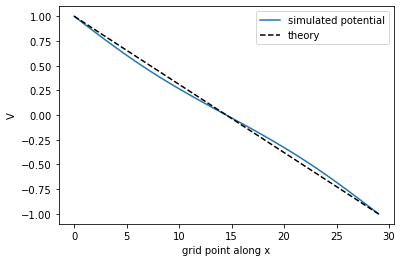

In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(V[:, Npoints_per_dimension//2], label='simulated potential')
#theory
x_th = np.arange(Npoints_per_dimension)
y_th = 1 - 2*x_th/(Npoints_per_dimension-1)
ax.plot(x_th, y_th, 'k--', label='theory')
ax.set_ylabel('V')
ax.set_xlabel('grid point along x')
ax.legend()

### Boundary conditions

The simulated potential is close to the one we know from theory, but it is not exactly the same. Why? Maybe the grid resolution is not large enough, or the convergence criterion is not strict enough. We can check both of these options by incrasing resolution and the threshold for convergence. Unfortunately, this is not the case.

The reason why thi scurve is not exactly as predicted has to do with the boundary conditions and numerical approximations. In setting up the problem, we assumed that the capacitor plates are infinite. However, it is impossible to properly simulate this in a computer! Therefore, we will always have effects due to the finite size of the plates. These can be seen by plotting the simulated potential at the edge of the capacitor:

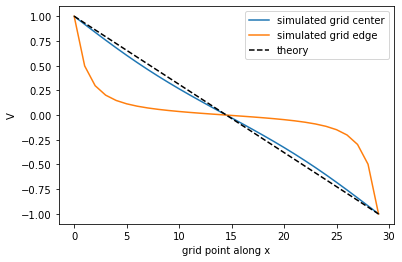

In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(V[:, Npoints_per_dimension//2], label='simulated grid center')
ax.plot(V[:, 1], label='simulated grid edge')
#theory
x_th = np.arange(Npoints_per_dimension)
y_th = 1 - 2*x_th/(Npoints_per_dimension-1)
ax.plot(x_th, y_th, 'k--', label='theory')
ax.set_ylabel('V')
ax.set_xlabel('grid point along x')
ax.legend()

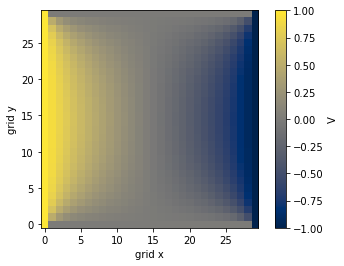

In [ ]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(V.T, cmap='cividis', origin='lower')
ax.set_xlabel('grid x')
ax.set_ylabel('grid y')

cb = fig.colorbar(im)
cb.set_label('V')

This may appear as an issue (and indeed it is one if we are interested in the infite-plates capacitor!), but also shows the power of numerical methods. In fact, it is possible to compute the potential for arbitrary configurations, while analytically we are restricted to few solved cases. For example, we can calculate the potential *outside* the (finite) capacitor! (<span style="color:darkgreen">optional exercise</span> do this, do spherical capacitor)

### Computing the electric field
To compute $\vec{E}$ form $V$ we simply apply finite differences. However, let's first pay attention to few things:
* Since we have made the assumption of a 2D system, our electric field will have only 2 components. The third one is zero because of the symmetry of the system.
* This is the first time where the physical length of the system enters into play, since we need to know $\Delta x$. Before, all term depending on this quantity cancelled out, showing that the internal potential configuration does not depend on the physical extent of the system.
* We have to be careful with boundaries. For instance, below we are using backward finite differences, but switch to forward finite differences when $i=0$ or $j=0$ (since we do not have other points available to compute the field).

In [ ]:
length = 1
Deltax = length / Npoints_per_dimension

E = np.zeros((Npoints_per_dimension, Npoints_per_dimension, 2))

for i in range(Npoints_per_dimension):
    for j in range(Npoints_per_dimension):
        if i==0:
            E[i,j,0] = (V[i+1,j] - V[i,j]) / Deltax
        else:
            E[i,j,0] = (V[i,j] - V[i-1,j]) / Deltax

        if j==0:
            E[i,j,1] = (V[i,j+1] - V[i,j]) / Deltax
        else:
            E[i,j,1] = (V[i,j] - V[i,j-1]) / Deltax

Text(0, 0.5, 'z')

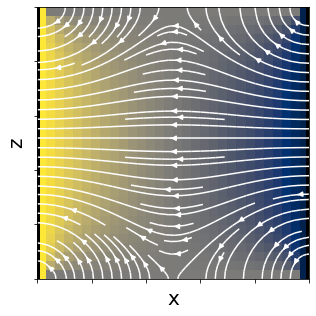

In [ ]:
#plot
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.vlines([0.0, 1.0], ymin=0, ymax=1, color='k', lw=6)

im = ax.imshow(V.T, cmap='cividis', origin='lower', extent=(0,1,0,1))

ax.streamplot(np.linspace(0,1,Npoints_per_dimension, endpoint=True),
              np.linspace(0,1,Npoints_per_dimension, endpoint=True),
              E[:, :,0].T, E[:, :,1].T, color='w')

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('z', fontsize=20)

## Convergence of the Jacobi method
An important measure of any computational algorithm is its *convegence*. This is a measure of how quickly an algorithm reach the solution (to a given accuracy) as a function of other properties. The Jacobi algorithm we have used has poor convergence properties. In fact, it can be proven that the number of iterations required to reach a given level of convergency scales as $L^2$ (where $L$ is the number of grid points per dimension. This means that to increase the resolution by a factor of $2$ in each direction, the total cost *for the same level of accuracy* increases as $L^{2+D}$, where the extra $L^D$ comes from the increase number of grid point where the computation needs to be performed. For instance, for a 3-dimentional system, just doubling the resolution increases the computatinal cost by a factor $32$. This is very large! (<span style='color:darkgreen;'>optional exercise: </span> verify this by measuring the time taken by the algorithm as function of the number of resolution elements).

## The Gauss-Seidel method
To see how we can improve over the Jacobi method, let's first rewrite the update equation for the Jacobi method highlighting when we use old and new guesses:

$$
V_{i,j,k}^{(new)} \approx \frac{1}{6} \left[ V_{i+1,j,k}^{(old)}+V_{i-1,j,k}^{(old)}+V_{i,j+1,k}^{(old)}+V_{i,j-1,k}^{(old)}+V_{i,j,k+1}^{(old)}+V_{i,j,k+1}^{(old)} \right]
$$

In this algorithm, we only use old values to compute the new ones. To improve on it, we can use the newly-computed values on the right-hand side as they become available. This is known as **Gauss-Seidel method**. The exact form of the right-hand side depends on the update order. A common approach is the so-called *red-black update order*, in which the update follows a pattern like the one in the figure.

<img src="https://www.researchgate.net/profile/Andang-Sunarto/publication/343600210/figure/fig2/AS:923565348110337@1597206546078/Finite-grid-of-red-black-strategy_Q640.jpg" width=250>

This approach is convenient because, practically, we do not need to change the formulas used and we do not need any more two arrays to store the current and new guesses. Instead, we simply update the guess *in place* (i.e. updating the guess in the same array), and we replace the loop over the grid dimensions by two loops. In the first one, we only update the red grid points, while in the second one we update only the black grid points.

In this way, the convergence of the method is improved, but only by a factor of $2$ (which, however, can be significant for large simulations; much better to wait $6$ months for a result than one year!). Although not precise, one can understand why this is the cae by recognizing that, in half of the updates, we already use the new (and hopefully better converged) values, speeding up the process of reaching the desired accuracy.

## Symultaneous over-relaxation (SOR)
The improvement brought by the Gauss-Seidel method is somewhat underwhelming. To improve on this, let's re-write the Gauss-Seidel method in order to highlight the change in the guess. **NB**: we could do the same with the Jacobi method, but it can be proven that this results in an unstable algorithm.

At each iteration, we compute a new guess $V^{(new)}$ from the last guess $V^{(old)}$. This means that we update our guess by a quantity $\Delta V =  V^{(new)} -  V^{(old)}$. If we are brave (and maybe desperate) enough, we may try to improve the rate of convergence by increasing the change in our guess at each step. After all, if the algorithm is moving towards the solution, pushing it a little bit will bring it there faster. This may not seem a good idea, but - surprisingly - it actually works! In this **symultaneous over-relaxation (SOR) algorithm**, we first compute the expected change $\Delta V$ (using the Gauss-Seidel method, to avoid instabilities!. Then, we apply a boosted change to the guess, i.e.:

$$
V^{(new)} = V^{(old)} + \alpha \Delta V = V^{(old)} + \alpha (V^{(new)} - V^{(old)})
$$

The parameter $\alpha$ determines how aggressive we want to be in our "over-relaxation" (or how much bold we feel that day). If we do not believe in SOR, we may choose $\alpha = 1$, and get back the good old Gauss-Seidel method. If we are too confident, and choose $\alpha \geq 2$, the method simply does not converge. But for reasonable choices of $\alpha$, we get a much better convergence (i.e., we reach the desired solution much faster!). For example, the number of iteration to reach a given accuracy scales linearly with the grid size $L$ (opposed to the $L^2$ scaling of the Jacobi and Gauss-Seidel algorithms). Unfortunately, the best value of $\alpha$ can not be determined *a priori* for all systems.


## The free-charges case
Let's breifly look now at the Laplace equation in the case when there are free chages around. Everything discussed so far still applies to this case, including the different algorithms, as long as we remember to retain the right-hand side of the Laplace equation $\rho / \epsilon$, representing the charge (density) distrbution. For the Jaconi method, this becomes

$$
V_{i,j,k} \approx \frac{1}{6} \left[ V_{i+1,j,k}+V_{i-1,j,k}+V_{i,j+1,k}+V_{i,j-1,k}+V_{i,j,k+1}+V_{i,j,k+1} \right] + \frac{\rho_{i,j,k} \Delta x^2}{6 \epsilon}
$$

One tricky thing to discuss is how to deal with the charge *density* when we have only an isolated charge $Q$. In this case, since we can not resolve anything beyond the grid resolution, we will simply compute the charge density as $\rho = Q / \Delta x^3$. Of course, in reality the charge is placed *smoewhere* within the grid cell, but we have no way to know where after we have discretised the system. This also means, of course, that the solution will not be completely accurate close to the charge, because of discretization/resolution effects!

### Re-discovering Coulomb's law
A first simple example of the free-charges case is the re-discovery of the Coulomb's law. For this, we just need to place a single cahrge in an otherwise-empty box, and compute its potential as a function of distance. Ideally, we would like the box to extend to infinity, but this is of course not possible. We will, however, take a box that is large enough for us to make the assumption that $V$ is negligible on its sides. Hence, we can use $V=0$ as boundary conditions.  

If we attack this problem using the Jacobi algorithm we developed above, we will need only few modifications. First of all, the boundary conditions:

In [ ]:
def apply_boundary_conditions(estimate):
    estimate[0,:] = 0
    estimate[-1,:] = 0
    estimate[:, 0] = 0
    estimate[:,-1] = 0
    return estimate

Next we need to set up the initial problem placing an individual charge in the box. It will be useful for th future to write a simple function that places a charge in the box, given its position. To remain as general as possible in our code, we will *add* the charge density to the grid, so that we can call the same functino multiple times to place multiple charges. Finally, to make thing easier, we will assume that the grid covers the range $[0, 1]$. (If this is not the case, we can just renormalize the grid and charge positions.)

In [ ]:
def place_many_charges(Ncharges, Qs, positions):
    for n in range(Ncharges):
        place_one_charge(Qs[n], positions[n], grid)


def place_one_charge(Q, position, grid):

    #determine number of dimensions and grid shape
    Ndim = grid.ndim
    Ngrid = grid.shape

    #loop over dimension (this can be skipped using numpy array operation, but writing this out makes things clearer)
    grid_index = []
    cell_volume = 1
    for d in range(Ndim):
        cell_volume *= 1./Ngrid[d]
        grid_index.append( [int(np.floor(position[d]/Deltax))] )

    #now add charge
    grid[grid_index] += Q/cell_volume

    return grid

We can now initialize (and visualize) our charge density as

/home/egaraldi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


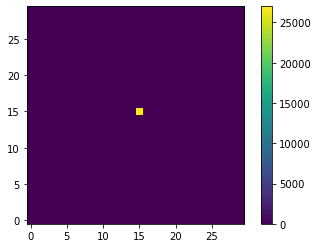

In [ ]:
rho = np.zeros((Npoints_per_dimension, Npoints_per_dimension, Npoints_per_dimension))

position = np.array([0.5, 0.5, 0.5])
rho = place_one_charge(1, position, rho)

ims= plt.imshow(rho[:,15, :], origin='lower')
plt.colorbar(ims)

Inserting these in the code for the Jacobi algorithm we developed, we get

In [ ]:
Npoints_per_dimension = 30
max_iterations_allowed = 10000
iteration_number = 0

#optional: make sure Npoints_per_dimension is an integer, otherwise numpy will (rightfully) complain
assert( isinstance(Npoints_per_dimension, int) )

def place_one_charge(Q, position, grid):

    #determine number of dimensions and grid shape
    Ndim = grid.ndim
    Ngrid = grid.shape

    #loop over dimension (this can be skipped using numpy array operation, but writing this out makes things clearer)
    grid_index = []
    cell_volume = 1
    for d in range(Ndim):
        cell_volume *= 1./Ngrid[d]
        grid_index.append( [int(np.floor(position[d]/Deltax))] )

    #now add charge
    grid[grid_index] += Q/cell_volume

    return grid

def apply_boundary_conditions(estimate):
    estimate[ 0,:,:] = 0
    estimate[-1,:,:] = 0
    estimate[:, 0,:] = 0
    estimate[:,-1,:] = 0
    estimate[:, :,0] = 0
    estimate[:,:,-1] = 0
    return estimate


def update_guess():
    for i in range(1, Npoints_per_dimension-1):
        for j in range(1, Npoints_per_dimension-1):
            for k in range(1, Npoints_per_dimension-1):
                new_guess[i,j,k] = (current_guess[i+1,j,k] + current_guess[i-1,j,k]
                                   +current_guess[i,j+1,k] + current_guess[i,j-1,k]
                                   +current_guess[i,j,k+1] + current_guess[i,j,k-1]
                                   ) / 6.0 + rho[i,j,k]*Deltax**2/6
    return


def is_converged(threshold=1e-5):
    abs_ratio = np.abs( new_guess / current_guess - 1 )
    #remove boundaries because of boundary conditions
    tot = np.nansum(abs_ratio)
    if tot <= threshold:
        return True
    else:
        return False


running = True

#create the grids
rho = np.zeros((Npoints_per_dimension, Npoints_per_dimension, Npoints_per_dimension))
rho = place_one_charge(1, np.array([0.5, 0.5, 0.5]), rho)
current_guess = np.zeros((Npoints_per_dimension, Npoints_per_dimension, Npoints_per_dimension))
Deltax = 1/Npoints_per_dimension

#set up initial guess
current_guess[:,:,:] = 0.0
apply_boundary_conditions(current_guess)

new_guess = current_guess.copy()


while running:
    print(f"iteration {iteration_number}", end='\r')
    update_guess()

    if is_converged(threshold=1e-1):
        print(f"SUCCESS! Convergence reached (after {iteration_number} iterations)!")
        running=False
    elif iteration_number >= max_iterations_allowed:
        print(f"WARNING: Maximum number of iterations ({max_iterations_allowed}) reached! The result is *not* converged to the desired level!")
        running=False
    else:
        current_guess = new_guess.copy()
        iteration_number += 1

/home/egaraldi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/egaraldi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/egaraldi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


SUCCESS! Convergence reached (after 1325 iterations)!


Text(0, 0.5, 'V')

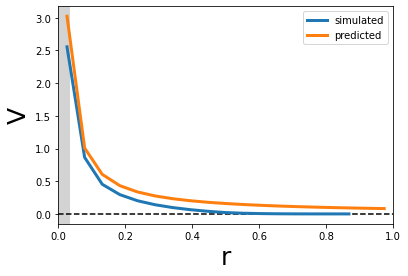

In [ ]:
fig, ax = plt.subplots(1,1)

#compute radial profile
xx,yy,zz = np.meshgrid(np.linspace(0, 1, Npoints_per_dimension), np.linspace(0, 1, Npoints_per_dimension), np.linspace(0, 1, Npoints_per_dimension))
r = ((xx-0.5)**2 + (yy-0.5)**2 + (zz-0.5)**2)**0.5
c, b, _ = binned_statistic(r.flatten(), new_guess.flatten(), bins=np.linspace(0,1,20), statistic='mean')

b = 0.5*(b[:-1] + b[1:])
ax.plot(b,c,'-', lw=3, label='simulated')
ax.plot(b,1/4/np.pi/np.array(b), lw=3, label='predicted')
ax.axhline(0.0, color='k', ls='--', zorder=-1)
ax.axvspan(0,Deltax, color='lightgrey', alpha=1, zorder=-2)
ax.legend()
ax.set_xlim([0,1])
ax.set_xlabel('r', fontsize=25)
ax.set_ylabel('V', fontsize=25)

#### Resolution and boundary effects
We have obtained a pretty good agreement with the well-known $1/r$ behaviour predicted by Coulomb's law. However, there are a couple of issues that need to be discussed.

The first one shows up close to the source, at $r \rightarrow 0$. Here, the simulated potential falls short of the predicted one. The reason is that here we are approaching the size of a single cell (grey band). Here the finite resolution of our simulation does not allow us to fully resolve the point-like charge (which is assumed in the Coulomb's law). In fact, the charge is spread over a cell size in our simulation, and the potential is consequently changed. This issue can be alleviated (but never completely solved!) by reducing the grid size.

The second difference is in the asymptotyc value reached at $r \rightarrow \infty$. Coulomb's law appears slightly above the simulated value of the potential. The reason for this difference is that, by setting up our boundary conditions, we impose the potential on the cube's surface to be zero, while in Coulomb's law such value is approached only at infinity. To alleviate this issue (but again without any hope to solve it completely), we can increase the length of the box.

Finally, let's think one minute about the symmetries of the system. We know that a single charge in vacuum has spherical symmetry. Our setup, however, does not. In particular, the corners of the box are farther away fromthe charge than the faces. One way to deal with this is to change our setup and the equation solved to have a spherical grid, i.e. one that has radial and angular directions as dimensions.
